In [1]:
%pylab nbagg

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import psycopg2
from matplotlib import animation
# import cartopy.crs as ccrs
from datetime import datetime, timedelta
from pathlib import Path
from os import listdir

In [3]:
from fastai import *
from fastai.tabular import *

ModuleNotFoundError: No module named 'numpy.testing.decorators'

In [4]:
# data_path = Path('../../data/new_york_311/311_Service_Requests_from_2010_to_Present.csv')
# orig_data = pd.read_csv(data_path)

In [5]:
def query_db(query):
    '''
    Runs sql query on 311 database and returns a pandas DataFrame.
    Redshift is a data warehouse based on PostgreSQL, so syntax is mostly the
    same
    '''
    host = 'interview-ds.ckgnwnm6pw4o.us-east-1.redshift.amazonaws.com'
    port = 5439
    db = 'interview'
    username = 'dsguest'
    password = 'nX9EFYUZ5Yu#0q'
    conn = psycopg2.connect(host=host, port=port, dbname=db, user=username,
    password=password)
    cur = conn.cursor()
    cur.execute(query)
    rows = cur.fetchall()

    rows = pd.DataFrame(rows)
    return rows


In [32]:
orig_data = query_db(f''' 
SELECT
  *
FROM
  public.three_one_one
ORDER BY RANDOM()
limit 2000000;''')
orig_data.columns = col_names


In [5]:
orig_data = pd.read_csv('data_311.csv')

C:\Users\efreiling\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (31,32) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
orig_data.head()

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,location_type,incident_zip,incident_address,...,vehicle_type,taxi_company_borough,taxi_pick_up_location,bridge_highway_name,bridge_highway_direction,road_ramp,bridge_highway_segment,latitude,longitude,location
0,30344685,2015-04-06 09:12:00,2015-04-08 12:00:00,DSNY,BCC - Brooklyn North,Missed Collection (All Materials),2 Bulk-Missed Collection,Sidewalk,11236.0,15 EAST 88 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.650824,-73.920302,"(40.650823560883765, -73.9203020905484)"
1,18336946,2010-07-24 20:37:00,2010-07-24 20:50:00,DEP,Department of Environmental Protection,Water System,Fire Hydrant Emergency (FHE),NaN,11237.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.701832,-73.919321,"(40.7018317851356, -73.91932144034594)"
2,21077563,2011-08-21 02:15:14,2011-08-21 05:10:12,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,Residential Building/House,11233.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.683498,-73.935154,"(40.68349849847838, -73.93515400522416)"
3,38448155,2018-02-12 12:43:30,2018-02-13 01:31:11,NYPD,New York City Police Department,Illegal Parking,Blocked Hydrant,Street/Sidewalk,11209.0,7201 RIDGE BOULEVARD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.634049,-74.029666,"(40.63404926192071, -74.02966617941425)"
4,21743239,2011-10-26 16:41:45,2011-11-01 10:24:46,DOT,Department of Transportation,Broken Muni Meter,No Receipt,Street,10023.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.780561,-73.980209,"(40.780561348235594, -73.98020912090448)"


In [8]:
from importlib import reload
import utils

ModuleNotFoundError: No module named 'numpy.testing.decorators'

In [4]:
orig_data.to_csv('data_311.csv', index=False)

NameError: name 'orig_data' is not defined

In [28]:
sizes = [100, 1000, 10000]
rand_time = []
lin_time = []
for ds in sizes:
    
    t = time.time()
    orig_data = query_db(f''' 
    SELECT
      *
    FROM
      public.three_one_one
    limit {ds};''')
    elapsed = time.time() - t
    lin_time.append(elapsed)
    
    t = time.time()
    orig_data = query_db(f''' 
    SELECT
      *
    FROM
      public.three_one_one
    limit {ds};''')
    elapsed = time.time() - t
    lin_time.append(elapsed)
    

21.433432579040527


In [22]:
data_size = 1000
q = f''' 
SELECT
  *
FROM
  public.three_one_one
ORDER BY RANDOM()
limit {data_size};'''
orig_data = query_db(q)

In [24]:
orig_data.head()

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
0,28885829,2014-09-15 18:20:01,2014-09-15 18:34:45,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,Residential Building/House,11365.0,65-56 PARSONS BOULEVARD,...,,,,,,,,40.734902214245416,-73.81062328797928,"(40.734902214245416, -73.81062328797928)"
1,18722449,2010-09-20 10:57:58,2010-09-20 12:09:12,TLC,Taxi and Limousine Commission,Taxi Complaint,Driver Complaint,,10001.0,371 7 AVENUE,...,,,Other,,,,,40.748806121566346,-73.99220435658970,"(40.748806121566346, -73.9922043565897)"
2,38847238,2018-04-02 09:57:10,2018-04-23 12:52:51,HPD,Department of Housing Preservation and Develop...,PAINT/PLASTER,WALL,RESIDENTIAL BUILDING,11385.0,56-60 MYRTLE AVENUE,...,,,,,,,,40.700327133142770,-73.90431312667518,"(40.70032713314277, -73.90431312667518)"
3,28574236,2014-07-29 11:47:40,2014-07-29 19:26:43,NYPD,New York City Police Department,Derelict Vehicle,With License Plate,Street/Sidewalk,11429.0,218-69 110 AVENUE,...,,,,,,,,40.708105486976685,-73.73803114966928,"(40.708105486976685, -73.73803114966928)"
4,29860883,2015-02-03 18:15:00,2015-02-04 12:00:00,DSNY,BCC - Queens East,Snow,15S Re-Plow/Spread/Ice-Snow Cond.,Street,11354.0,155-20 41 AVENUE,...,,,,,,,,40.762933309564765,-73.80996600789160,"(40.762933309564765, -73.8099660078916)"


In [15]:
q = ''' 
SELECT
  complaint_type,
  COUNT(*) AS count
FROM
  public.three_one_one
GROUP BY
  complaint_type
ORDER BY count DESC;'''
compl_df = query_db(q)
compl_df

,0,1
0,Noise - Residential,1722501
1,HEAT/HOT WATER,1149728
2,Street Condition,939603
3,Street Light Condition,891730
4,HEATING,887869
5,Blocked Driveway,867920
6,Illegal Parking,839945
7,PLUMBING,701818
8,Water System,630164
9,GENERAL CONSTRUCTION,500863


<IPython.core.display.Javascript object>


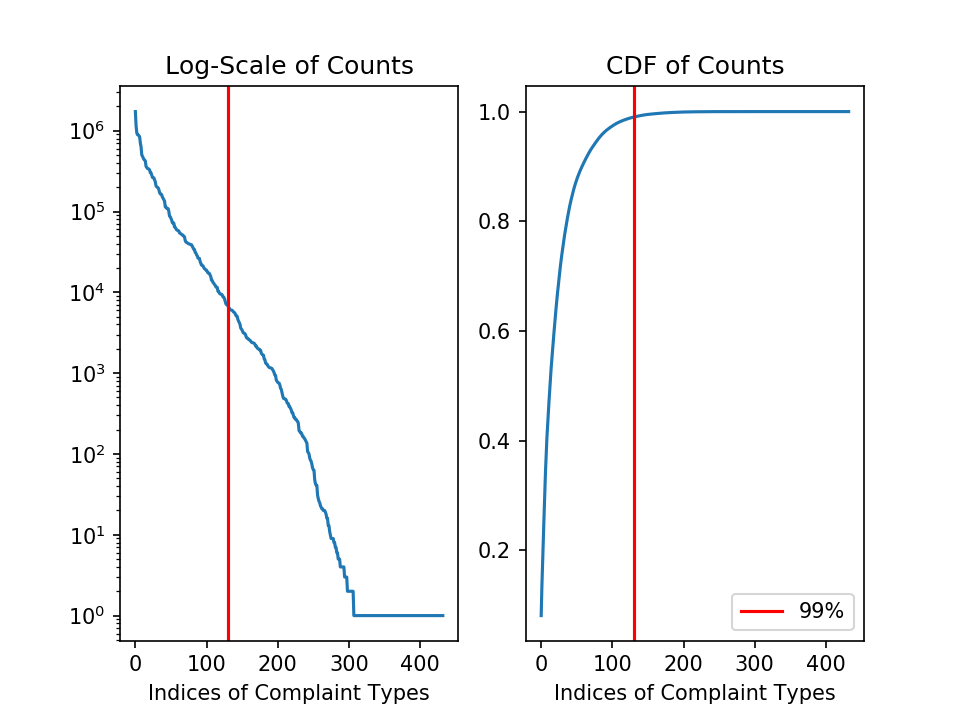

In [16]:
cdf = np.cumsum(compl_df[1].values) / np.sum(compl_df[1].values)
loc = np.where(cdf > .99)[0]
idx_cutoff = loc[0]
figure()
subplot(121)
semilogy(compl_df[1].values)
title('Log-Scale of Counts')
xlabel('Indices of Complaint Types')
axvline(x=idx_cutoff, color='r')

subplot(122)
plot(cdf)
title('CDF of Counts')
xlabel('Indices of Complaint Types')
axvline(x=idx_cutoff, color='r', label='99%')
legend()

In [17]:
complaint_types = list(compl_df[0].values[0:idx_cutoff])
sorted_types = list(compl_df[0].values[0:idx_cutoff])
sorted_types.sort()
sorted_types


['APPLIANCE',
 'Abandoned Vehicle',
 'Air Quality',
 'Animal Abuse',
 'Animal in a Park',
 'Asbestos',
 'BEST/Site Safety',
 'Benefit Card Replacement',
 'Blocked Driveway',
 'Boilers',
 'Borough Office',
 'Broken Muni Meter',
 'Broken Parking Meter',
 'Building Marshals office',
 'Building/Use',
 'Bus Stop Shelter Complaint',
 'Construction',
 'Construction Safety Enforcement',
 'Consumer Complaint',
 'Curb Condition',
 'DCA / DOH New License Application Request',
 'DHS Advantage - Tenant',
 'DHS Advantage -Landlord/Broker',
 'DOF Parking - Payment Issue',
 'DOF Parking - Request Copy',
 'DOF Parking - Request Status',
 'DOF Property - Owner Issue',
 'DOF Property - Payment Issue',
 'DOF Property - Reduction Issue',
 'DOF Property - Request Copy',
 'DOF Property - Update Account',
 'DOOR/WINDOW',
 'DPR Internal',
 'Damaged Tree',
 'Dead Tree',
 'Dead/Dying Tree',
 'Derelict Bicycle',
 'Derelict Vehicle',
 'Derelict Vehicles',
 'Dirty Conditions',
 'Drinking',
 'ELECTRIC',
 'Electrical

In [16]:
np.save(save_path / 'labels', sorted_types)

In [18]:
save_path = Path('../Saved_Models')
labels = np.load(save_path / 'labels.npy')
for l in labels:
    print(f"'{l}'" + ',')

'APPLIANCE',
'Abandoned Vehicle',
'Air Quality',
'Animal Abuse',
'Animal in a Park',
'Asbestos',
'BEST/Site Safety',
'Benefit Card Replacement',
'Blocked Driveway',
'Boilers',
'Borough Office',
'Broken Muni Meter',
'Broken Parking Meter',
'Building Marshals office',
'Building/Use',
'Bus Stop Shelter Complaint',
'Construction',
'Construction Safety Enforcement',
'Consumer Complaint',
'Curb Condition',
'DCA / DOH New License Application Request',
'DHS Advantage - Tenant',
'DHS Advantage -Landlord/Broker',
'DOF Parking - Payment Issue',
'DOF Parking - Request Copy',
'DOF Parking - Request Status',
'DOF Property - Owner Issue',
'DOF Property - Payment Issue',
'DOF Property - Reduction Issue',
'DOF Property - Request Copy',
'DOF Property - Update Account',
'DOOR/WINDOW',
'DPR Internal',
'Damaged Tree',
'Dead Tree',
'Dead/Dying Tree',
'Derelict Bicycle',
'Derelict Vehicle',
'Derelict Vehicles',
'Dirty Conditions',
'Drinking',
'ELECTRIC',
'Electrical',
'Electronics Waste',
'Elevator',
'Emerge

In [9]:
col_names = [
    'unique_key',
    'created_date',
    'closed_date',
    'agency',
    'agency_name',
    'complaint_type',
    'descriptor',
    'location_type',
    'incident_zip',
    'incident_address',
    'street_name',
    'cross_street_1',
    'cross_street_2',
    'intersection_street_1',
    'intersection_street_2',
    'address_type',
    'city',
    'landmark',
    'facility_type',
    'status',
    'due_date',
    'resolution_description',
    'resolution_action_updated_date',
    'community_board',
    'bbl',
    'borough',
    'x_coordinate_state_plane',
    'y_coordinate_state_plane',
    'open_data_channel_type',
    'park_facility_name',
    'park_borough',
    'vehicle_type',
    'taxi_company_borough',
    'taxi_pick_up_location',
    'bridge_highway_name',
    'bridge_highway_direction',
    'road_ramp',
    'bridge_highway_segment',
    'latitude',
    'longitude',
    'location'
]

In [10]:
orig_data.columns = col_names

In [12]:
orig_data.head()

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,location_type,incident_zip,incident_address,...,vehicle_type,taxi_company_borough,taxi_pick_up_location,bridge_highway_name,bridge_highway_direction,road_ramp,bridge_highway_segment,latitude,longitude,location
0,30344685,2015-04-06 09:12:00,2015-04-08 12:00:00,DSNY,BCC - Brooklyn North,Missed Collection (All Materials),2 Bulk-Missed Collection,Sidewalk,11236.0,15 EAST 88 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.650824,-73.920302,"(40.650823560883765, -73.9203020905484)"
1,18336946,2010-07-24 20:37:00,2010-07-24 20:50:00,DEP,Department of Environmental Protection,Water System,Fire Hydrant Emergency (FHE),NaN,11237.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.701832,-73.919321,"(40.7018317851356, -73.91932144034594)"
2,21077563,2011-08-21 02:15:14,2011-08-21 05:10:12,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,Residential Building/House,11233.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.683498,-73.935154,"(40.68349849847838, -73.93515400522416)"
3,38448155,2018-02-12 12:43:30,2018-02-13 01:31:11,NYPD,New York City Police Department,Illegal Parking,Blocked Hydrant,Street/Sidewalk,11209.0,7201 RIDGE BOULEVARD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.634049,-74.029666,"(40.63404926192071, -74.02966617941425)"
4,21743239,2011-10-26 16:41:45,2011-11-01 10:24:46,DOT,Department of Transportation,Broken Muni Meter,No Receipt,Street,10023.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.780561,-73.980209,"(40.780561348235594, -73.98020912090448)"


In [23]:
orig_data.dtypes

unique_key                                 int64
created_date                      datetime64[ns]
closed_date                       datetime64[ns]
agency                                    object
agency_name                               object
complaint_type                            object
descriptor                                object
location_type                             object
incident_zip                             float64
incident_address                          object
street_name                               object
cross_street_1                            object
cross_street_2                            object
intersection_street_1                     object
intersection_street_2                     object
address_type                              object
city                                      object
landmark                                  object
facility_type                             object
status                                    object
due_date            

# Get rid of bad complaint types

In [13]:
save_path = Path('../Saved_Models')
def filter_complaint_type(df):
    labels = np.load(save_path / 'labels.npy')
    return df[df['complaint_type'].isin(labels)]

In [14]:
df = filter_complaint_type(orig_data)
df.head()

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,location_type,incident_zip,incident_address,...,vehicle_type,taxi_company_borough,taxi_pick_up_location,bridge_highway_name,bridge_highway_direction,road_ramp,bridge_highway_segment,latitude,longitude,location
0,30344685,2015-04-06 09:12:00,2015-04-08 12:00:00,DSNY,BCC - Brooklyn North,Missed Collection (All Materials),2 Bulk-Missed Collection,Sidewalk,11236.0,15 EAST 88 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.650824,-73.920302,"(40.650823560883765, -73.9203020905484)"
1,18336946,2010-07-24 20:37:00,2010-07-24 20:50:00,DEP,Department of Environmental Protection,Water System,Fire Hydrant Emergency (FHE),NaN,11237.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.701832,-73.919321,"(40.7018317851356, -73.91932144034594)"
2,21077563,2011-08-21 02:15:14,2011-08-21 05:10:12,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,Residential Building/House,11233.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.683498,-73.935154,"(40.68349849847838, -73.93515400522416)"
3,38448155,2018-02-12 12:43:30,2018-02-13 01:31:11,NYPD,New York City Police Department,Illegal Parking,Blocked Hydrant,Street/Sidewalk,11209.0,7201 RIDGE BOULEVARD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.634049,-74.029666,"(40.63404926192071, -74.02966617941425)"
4,21743239,2011-10-26 16:41:45,2011-11-01 10:24:46,DOT,Department of Transportation,Broken Muni Meter,No Receipt,Street,10023.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.780561,-73.980209,"(40.780561348235594, -73.98020912090448)"


In [ ]:
df['totals.bounces'] = train_df['totals.bounces'].fillna('0')

In [18]:
i += 1
c = col_names[i]
df[c].head()

0    2015-04-06 09:12:00
1    2010-07-24 20:37:00
2    2011-08-21 02:15:14
3    2018-02-12 12:43:30
4    2011-10-26 16:41:45
Name: created_date, dtype: object

# Drop columns that don't add anything

In [19]:
drop_cols = [
    'unique_key',        # If interested in leakage, investigate this column
    'agency_name',       # Redundant to agancy
    'descriptor',        # This gives away the complaint type, too easy
    'incident_address',  # Didnt want street numbers, too easy
    'bbl',               # We already have enough goelocaions
    'location',           # Redundant to Lat and Lng
    'resolution_action_updated_date', # caused errors
]
df = df.drop(columns=drop_cols)
df.head()

,created_date,closed_date,agency,complaint_type,location_type,incident_zip,street_name,cross_street_1,cross_street_2,intersection_street_1,...,park_borough,vehicle_type,taxi_company_borough,taxi_pick_up_location,bridge_highway_name,bridge_highway_direction,road_ramp,bridge_highway_segment,latitude,longitude
0,2015-04-06 09:12:00,2015-04-08 12:00:00,DSNY,Missed Collection (All Materials),Sidewalk,11236.0,EAST 88 STREET,RALPH AVENUE,AVENUE A,NaN,...,BROOKLYN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.650824,-73.920302
1,2010-07-24 20:37:00,2010-07-24 20:50:00,DEP,Water System,NaN,11237.0,NaN,NaN,NaN,IRVING AVENUE,...,BROOKLYN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.701832,-73.919321
2,2011-08-21 02:15:14,2011-08-21 05:10:12,NYPD,Noise - Residential,Residential Building/House,11233.0,NaN,NaN,NaN,HALSEY STREET,...,BROOKLYN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.683498,-73.935154
3,2018-02-12 12:43:30,2018-02-13 01:31:11,NYPD,Illegal Parking,Street/Sidewalk,11209.0,RIDGE BOULEVARD,72 STREET,73 STREET,NaN,...,BROOKLYN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.634049,-74.029666
4,2011-10-26 16:41:45,2011-11-01 10:24:46,DOT,Broken Muni Meter,Street,10023.0,NaN,NaN,NaN,AMSTERDAM AVENUE,...,MANHATTAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.780561,-73.980209


# Create new features for differences in time

In [20]:
df['created_date'] = pd.to_datetime(df['created_date'])
df['closed_date'] = pd.to_datetime(df['closed_date'])
df['due_date'] = pd.to_datetime(df['due_date'])

In [21]:
df['time_to_close'] = (df['closed_date']-df['created_date']).astype('timedelta64[h]')
df['due_len'] = (df['due_date']-df['created_date']).astype('timedelta64[h]')
df['time_over'] = (df['due_date']-df['closed_date']).astype('timedelta64[h]')
# df['updated_time'] = (df['resolution_action_updated_date']-df['created_date']).astype('timedelta64[h]')

# Convert date columns to better features

In [22]:
date_cols = [
    'created_date',
    'closed_date',
    # 'resolution_action_updated_date',
    'due_date'
]
for d in date_cols:
    add_datepart(df, d, drop=True)
df.head()

,agency,complaint_type,location_type,incident_zip,street_name,cross_street_1,cross_street_2,intersection_street_1,intersection_street_2,address_type,...,due_Day,due_Dayofweek,due_Dayofyear,due_Is_month_end,due_Is_month_start,due_Is_quarter_end,due_Is_quarter_start,due_Is_year_end,due_Is_year_start,due_Elapsed
0,DSNY,Missed Collection (All Materials),Sidewalk,11236.0,EAST 88 STREET,RALPH AVENUE,AVENUE A,NaN,NaN,ADDRESS,...,NaN,NaN,NaN,False,False,False,False,False,False,-9223372037
1,DEP,Water System,NaN,11237.0,NaN,NaN,NaN,IRVING AVENUE,STANHOPE STREET,INTERSECTION,...,NaN,NaN,NaN,False,False,False,False,False,False,-9223372037
2,NYPD,Noise - Residential,Residential Building/House,11233.0,NaN,NaN,NaN,HALSEY STREET,LEWIS AVENUE,INTERSECTION,...,21.0,6.0,233.0,False,False,False,False,False,False,1313921714
3,NYPD,Illegal Parking,Street/Sidewalk,11209.0,RIDGE BOULEVARD,72 STREET,73 STREET,NaN,NaN,ADDRESS,...,12.0,0.0,43.0,False,False,False,False,False,False,1518468210
4,DOT,Broken Muni Meter,Street,10023.0,NaN,NaN,NaN,AMSTERDAM AVENUE,WEST 75 STREET,INTERSECTION,...,9.0,2.0,313.0,False,False,False,False,False,False,1320856905


# We can do some parsing, bag of words, etc to create more features if time allows

In [23]:
text_cols = [
    'resolution_description'
]
# Remove original date columns
df = df.drop(columns=text_cols)

In [32]:
cont_cols = [
    'x_coordinate_state_plane',
    'y_coordinate_state_plane',
    'latitude',
    'longitude',
    'time_to_close',
    'due_len',
    'time_over',
    'updated_time'
]
cat_cols = [
    'agency',
    'borough',
    'location_type',
    'incident_zip',
    'street_name',
    'cross_street_1',
    'cross_street_2',
    'intersection_street_1',
    'intersection_street_2',
    'address_type',
    'city',
    'landmark',
    'facility_type',
    'status',
    'community_board',
    'open_data_channel_type',
    'park_facility_name',
    'park_borough',
    'vehicle_type',
    'taxi_company_borough',
    'taxi_pick_up_location',
    'bridge_highway_name',
    'bridge_highway_direction',
    'road_ramp',
    'bridge_highway_segment',
]

dep_var = ['complaint_type']

In [36]:
created_cols = list(set(df.columns) - set(cont_cols) - set(cat_cols) - set(dep_var))
all_cat_cols = cat_cols + created_cols

In [44]:
cont_cols[0] in nan_cols

True

In [47]:
set(df.columns[df.isna().any()]) & set(cont_cols)

{'due_len',
 'latitude',
 'longitude',
 'time_over',
 'time_to_close',
 'x_coordinate_state_plane',
 'y_coordinate_state_plane'}

In [60]:
df[['due_len', 'due_len_missing']].head()

,due_len,due_len_missing
0,8.0,1.0
1,8.0,1.0
2,8.0,0.0
3,8.0,0.0
4,336.0,0.0


In [64]:
nan_loc = np.where(df[dc].isna())[0]
good_loc = np.where(df[dc].notna())[0]

In [69]:
nan_cols = list(set(df.columns[df.isna().any()]) & set(cat_cols))

In [70]:
nan_cols

['status',
 'facility_type',
 'park_facility_name',
 'intersection_street_2',
 'taxi_pick_up_location',
 'cross_street_1',
 'city',
 'intersection_street_1',
 'borough',
 'street_name',
 'landmark',
 'bridge_highway_direction',
 'road_ramp',
 'address_type',
 'location_type',
 'bridge_highway_segment',
 'taxi_company_borough',
 'cross_street_2',
 'incident_zip',
 'vehicle_type',
 'bridge_highway_name',
 'park_borough']

In [1]:
import sys
print(sys.executable)

C:\Users\efreiling\AppData\Local\Continuum\anaconda3\python.exe


In [1]:
import utils

ImportError: Something is wrong with the numpy installation. While importing we detected an older version of numpy in ['C:\\Users\\efreiling\\AppData\\Local\\Continuum\\anaconda3\\lib\\site-packages\\numpy']. One method of fixing this is to repeatedly uninstall numpy until none is found, then reinstall this version.

In [86]:
df['location_type'] = df['location_type'].fillna('missing')


In [91]:
x = df['location_type'].values
u_vals = df['location_type'].unique()

In [93]:
for i, v in enumerate(u_vals):
    x[x == v] = i

In [114]:
my_df = pd.get_dummies(df['agency'])

In [115]:
new_col_names = ['agency' + '=' + n for n in my_df.columns]


In [116]:
my_df.columns = new_col_names

In [117]:
my_df.head()

,agency=3-1-1,agency=DCA,agency=DEP,agency=DFTA,agency=DHS,agency=DOB,agency=DOE,agency=DOF,agency=DOHMH,agency=DOT,agency=DPR,agency=DSNY,agency=EDC,agency=HPD,agency=HRA,agency=NYCEM,agency=NYPD,agency=TLC
0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [82]:
for c in cat_cols:
    print(f'{c}: {df[c].nunique()}')

agency: 18
borough: 6
location_type: 118
incident_zip: 722
street_name: 17950
cross_street_1: 18386
cross_street_2: 18535
intersection_street_1: 12511
intersection_street_2: 13102
address_type: 5
city: 612
landmark: 3383
facility_type: 3
status: 10
community_board: 78
open_data_channel_type: 6
park_facility_name: 2237
park_borough: 6
vehicle_type: 4
taxi_company_borough: 10
taxi_pick_up_location: 1149
bridge_highway_name: 46
bridge_highway_direction: 44
road_ramp: 2
bridge_highway_segment: 863


In [77]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [72]:
le = LabelEncoder()

NameError: name 'LabelEncoder' is not defined

In [71]:
df['status'].unique()

array(['Closed', 'Open', 'Pending', 'In Progress', 'Started', 'Assigned', 'Unassigned', 'Draft', 'Unspecified', nan,
       'Closed - Testing'], dtype=object)

In [57]:
nan_cols = list(set(df.columns[df.isna().any()]) & set(cont_cols))
nc = nan_cols[0]
nan_loc = np.where(df[dc].isna())[0]
good_loc = np.where(df[dc].notna())[0]
med = np.median(df[dc].values[good_loc])
x = df[dc].values
x[nan_loc] = med
indicator = np.zeros(len(x))
indicator[nan_loc] = 1
df[dc] = x
df[dc + '_missing'] = indicator


In [51]:
dc = 'due_len'
nan_loc = np.where(df[dc].isna())[0]

In [54]:
t_loc = np.array([1, 2])
x = np.arange(10)

In [56]:
x[~t_loc]

array([8, 7])

In [53]:
len(x[~nan_loc])

1192768

In [41]:
x = df[cont_cols[0]].values

df['temp'] = (x - np.mean(x)) / np.std(x)

In [42]:
df['temp'].head()

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: temp, dtype: float64

In [43]:
nan_cols = df.columns[df.isna().any()].tolist()

In [21]:
tfm = Categorify(cat_cols, cont_cols)


In [36]:
from sklearn.feature_extraction import DictVectorizer

In [37]:
DictVectorizer(df['location_type'])

DictVectorizer(dtype=0                            Sidewalk
1                                 NaN
2          Residential Building/House
3                     Street/Sidewalk
4                              Street
5                                 NaN
6                                 NaN
7                RESIDENTIAL...ed Use Building < 1-3 Family Dwelling ... Vacant Building < Vacant Land < Vacant Lot < Vehicle Lane],
        separator='=', sort=True, sparse=True)

In [44]:
tfm.apply_train(df)

In [46]:
tfm.cat_names

['agency',
 'location_type',
 'incident_zip',
 'street_name',
 'cross_street_1',
 'cross_street_2',
 'intersection_street_1',
 'intersection_street_2',
 'address_type',
 'city',
 'landmark',
 'facility_type',
 'status',
 'community_board',
 'open_data_channel_type',
 'park_facility_name',
 'park_borough',
 'vehicle_type',
 'taxi_company_borough',
 'taxi_pick_up_location',
 'bridge_highway_name',
 'bridge_highway_direction',
 'road_ramp',
 'bridge_highway_segment']

In [35]:
df['location_type'].cat.categories

Index(['1-, 2- and 3- Family Home', '1-2 Family Dwelling',
       '1-2 Family Mixed Use Building', '1-3 Family Dwelling',
       '1-3 Family Mixed Use Building', '3+ Family Apartment Building',
       '3+ Family Apt. Building', '3+ Family Mixed Use Building',
       'Abandoned Building', 'Above Address',
       ...
       'Summer Camp', 'Tenant Address', 'Terminal', 'Theater', 'Tire Shop',
       'Utility', 'Vacant Building', 'Vacant Land', 'Vacant Lot',
       'Vehicle Lane'],
      dtype='object', length=118)

# I would like to do 5 fold validation, 
##   - Mixing up future and past might not be best
##  - If time allows, mix up df and compare results

In [19]:
train_perc = 0.8
valid_idx = int(len(df) * train_perc)
# train_df, valid_df = df.iloc[:valid_idx].copy(), df.iloc[valid_idx:].copy()
# len(train_df), len(valid_df)

In [20]:
procs = [FillMissing, Categorify, Normalize] # FillMissing
dep_var = 'complaint_type'

In [21]:
df['latitude'] = df['latitude'].astype('double')
df['longitude'] = df['longitude'].astype('double')

In [22]:
data = (TabularList.from_df(df, path='.', cat_names=cat_cols, cont_names=cont_cols, procs=procs)
                        .split_by_idx(list(range(valid_idx,len(df))))
                        .label_from_df(cols = dep_var)
                        .databunch())

In [23]:
data.show_batch(rows=10)

agency,location_type,incident_zip,street_name,cross_street_1,cross_street_2,intersection_street_1,intersection_street_2,address_type,city,landmark,facility_type,status,community_board,open_data_channel_type,park_facility_name,park_borough,vehicle_type,taxi_company_borough,taxi_pick_up_location,bridge_highway_name,bridge_highway_direction,road_ramp,bridge_highway_segment,x_coordinate_state_plane_na,y_coordinate_state_plane_na,latitude_na,longitude_na,time_to_close_na,due_len_na,time_over_na,updated_time_na,x_coordinate_state_plane,y_coordinate_state_plane,latitude,longitude,time_to_close,due_len,time_over,updated_time,target
HPD,RESIDENTIAL BUILDING,11433.0,SOUTH ROAD,164 STREET,165 STREET,,,ADDRESS,JAMAICA,,N/A,Closed,0 Unspecified,UNKNOWN,Unspecified,Unspecified,,,,,,,,False,False,False,False,False,True,True,False,1.8138,-0.4283,-0.4298,1.8127,0.0434,0.0663,0.0239,-0.1553,GENERAL CONSTRUCTION
DEP,,10032.0,AMSTERDAM AVENUE,W 166 ST,W 167 ST,,,ADDRESS,NEW YORK,,N/A,Closed,12 MANHATTAN,UNKNOWN,Unspecified,MANHATTAN,,,,,,,,False,False,False,False,False,True,True,False,-0.1950,1.1900,1.1905,-0.1943,0.0415,0.0663,0.0239,-0.2035,Water System
HPD,RESIDENTIAL BUILDING,11206.0,BOERUM STREET,BUSHWICK PLACE,WHITE STREET,,,ADDRESS,BROOKLYN,,N/A,Closed,0 Unspecified,UNKNOWN,Unspecified,Unspecified,,,,,,,,False,False,False,False,False,True,True,False,-0.1875,-0.3586,-0.3581,-0.1886,0.0529,0.0663,0.0239,0.0887,ELECTRIC
DOT,,11363.0,,,,42 AVENUE,LITTLE NECK PARKWAY,INTERSECTION,LITTLE NECK,,N/A,Closed,11 QUEENS,UNKNOWN,Unspecified,QUEENS,,,,,,,,False,False,False,False,False,True,True,False,2.5599,0.3964,0.3936,2.5627,0.0414,0.0663,0.0239,-0.2142,Street Light Condition
DPR,Street,11213.0,MONTGOMERY STREET,KINGSTON AVENUE,ALBANY AVENUE,,,ADDRESS,BROOKLYN,,N/A,Closed,09 BROOKLYN,PHONE,Unspecified,BROOKLYN,,,,,,,,False,False,False,False,False,False,False,False,-0.2434,-0.8444,-0.8439,-0.2450,0.0483,0.0816,0.0341,-0.0376,Damaged Tree
HPD,RESIDENTIAL BUILDING,10463.0,JACOBUS PLACE,WEST 225 STREET,FT CHARLES PLACE,,,ADDRESS,NEW YORK,,N/A,Closed,0 Unspecified,UNKNOWN,Unspecified,Unspecified,,,,,,,,False,False,False,False,False,True,True,False,0.1643,1.6182,1.6184,0.1664,0.0434,0.0663,0.0239,-0.1553,HEATING
NYPD,Street/Sidewalk,11385.0,73 STREET,CENTRAL AVENUE,COOPER AVENUE,,,ADDRESS,RIDGEWOOD,,Precinct,Closed,05 QUEENS,PHONE,Unspecified,QUEENS,,,,,,,,False,False,False,False,False,False,False,False,0.6382,-0.3727,-0.3728,0.6372,0.0415,0.0639,0.0239,-0.2163,Blocked Driveway
HPD,RESIDENTIAL BUILDING,11365.0,56 AVENUE,175 STREET,175 PLACE,,,ADDRESS,FRESH MEADOWS,,N/A,Closed,0 Unspecified,UNKNOWN,Unspecified,Unspecified,,,,,,,,False,False,False,False,False,True,True,False,1.7931,0.0691,0.0676,1.7938,0.0620,0.0663,0.0239,0.3199,GENERAL CONSTRUCTION
HPD,RESIDENTIAL BUILDING,11212.0,EAST 98 STREET,NEWPORT STREET,SARATOGA AVENUE,,,ADDRESS,BROOKLYN,,N/A,Closed,0 Unspecified,UNKNOWN,Unspecified,Unspecified,,,,,,,,False,False,False,False,False,True,True,False,0.1153,-0.9215,-0.9212,0.1134,0.0434,0.0663,0.0239,-0.1553,ELECTRIC
DOT,,11221.0,DE KALB AVENUE,EVERGREEN AVENUE,MYRTLE AVENUE,,,ADDRESS,BROOKLYN,,N/A,Closed,Unspecified BROOKLYN,UNKNOWN,Unspecified,BROOKLYN,,,,,,,,False,False,False,False,False,True,True,False,-0.0390,-0.4693,-0.4689,-0.0401,0.0417,0.0663,0.0239,-0.1981,Street Condition


In [25]:
import lightgbm as lgb

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [172]:
learn = tabular_learner(data, layers=[200, 100], metrics=accuracy)
learn.fit(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time


KeyboardInterrupt: 